In [2]:
# # run only if scipy is not already installed
# !pip install -q scipy

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({"font.size": 17, 'figure.figsize': [15, 7]})
FIGSIZE = (15, 7)

In [2]:
carbon = pd.read_csv(filepath_or_buffer="data/citylearn_challenge_2022_phase_1/carbon_intensity.csv")
carbon.head()
c = np.squeeze(carbon[:100].values)
t = np.arange(100)

In [3]:
from scipy import optimize

def sine_func(x, a, b, phi):
    return a * np.sin(2 * np.pi * x / 24 + phi) + b

s = np.exp(-(t - t[-1])/48) # we take 48 because curve_fit uses s**(-2)
params, params_covariance = optimize.curve_fit(sine_func, t, c, p0=[.05, .2, 0.5], sigma=s)
params

array([-0.04519155,  0.20157431,  0.72553952])

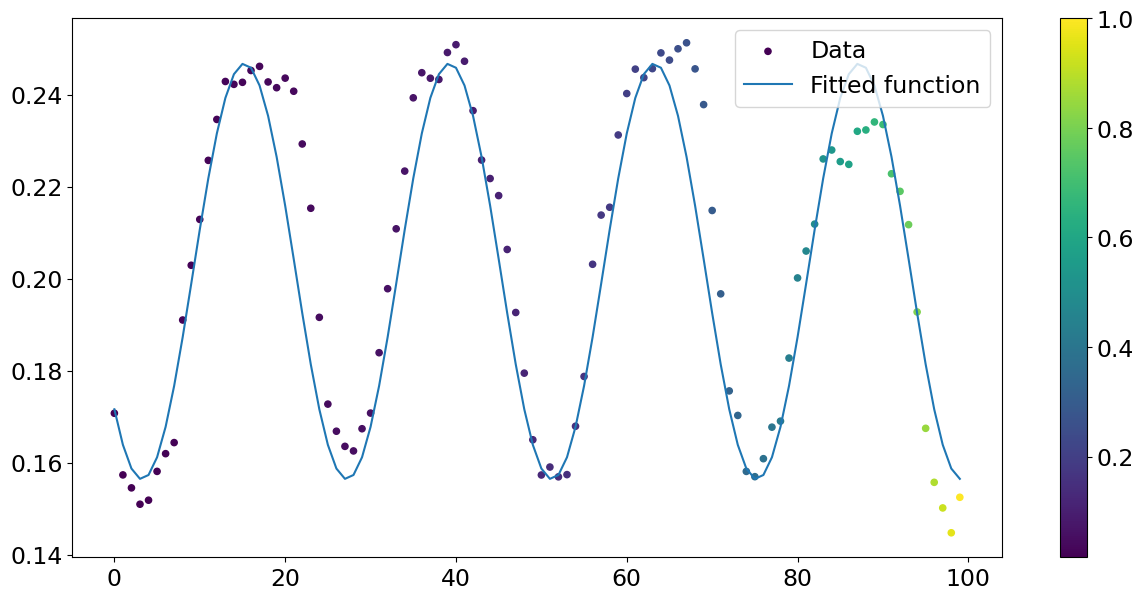

In [4]:
plt.figure()
plt.scatter(t, c, 20, s**(-2), label='Data')
plt.plot(t, sine_func(t, params[0], params[1], params[2]),
         label='Fitted function')
plt.colorbar()
plt.legend(loc='best')
plt.show()

In [5]:
c = np.squeeze(carbon.values)
t = np.arange(len(c))
g = []
params = [.05, .2, 0.5]
s = np.exp((np.arange(48)-48)/2/48)  # we take 48 because curve_fit uses s**(-2)
s = s/np.sum(s)

for h in np.arange(len(c)-24)+24:
    if h < 48:
        cur_t = t[:h]
        cur_c = c[:h]
    else:
        cur_t = t[h-48:h]
        cur_c = c[h-48:h]
        
    params, _ = optimize.curve_fit(sine_func, cur_t, cur_c, p0=params, sigma=s[:h])
    g = np.append(g, sine_func(h+24, params[0], params[1], params[2]))
    

In [6]:
print('relative l1 error = ' + str(np.mean(abs(g-c[:-24]))/np.mean(c[:-24])))
print('relative l2 error = ' + str(np.std(g-c[:-24])/np.std(c[:-24])))

relative l1 error = 0.056695086764228284
relative l2 error = 0.3161660997846275


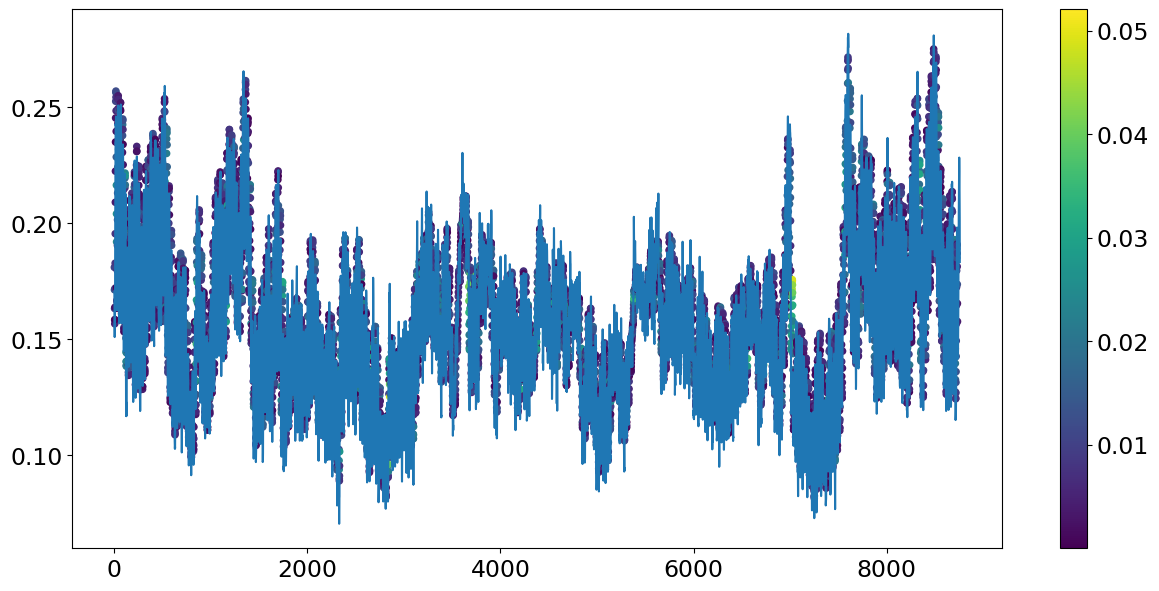

In [7]:
plt.figure()
plt.plot(t, c)
plt.scatter(t[:-24], g, 20, abs(g-c[:-24]))
plt.colorbar()
plt.show()

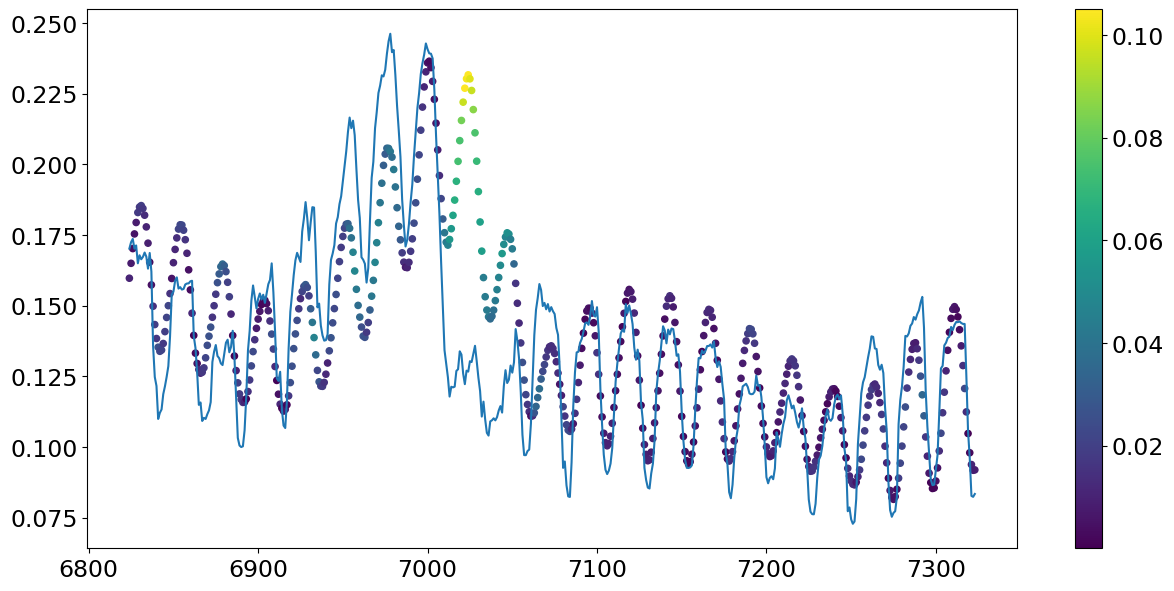

In [8]:
plt.figure()
plt.plot(t[6824:7324], c[6824:7324])
plt.scatter(t[6824:7324], g[6800:7300], 20, abs(g[6800:7300]-c[6824:7324]))
plt.colorbar()
plt.show()

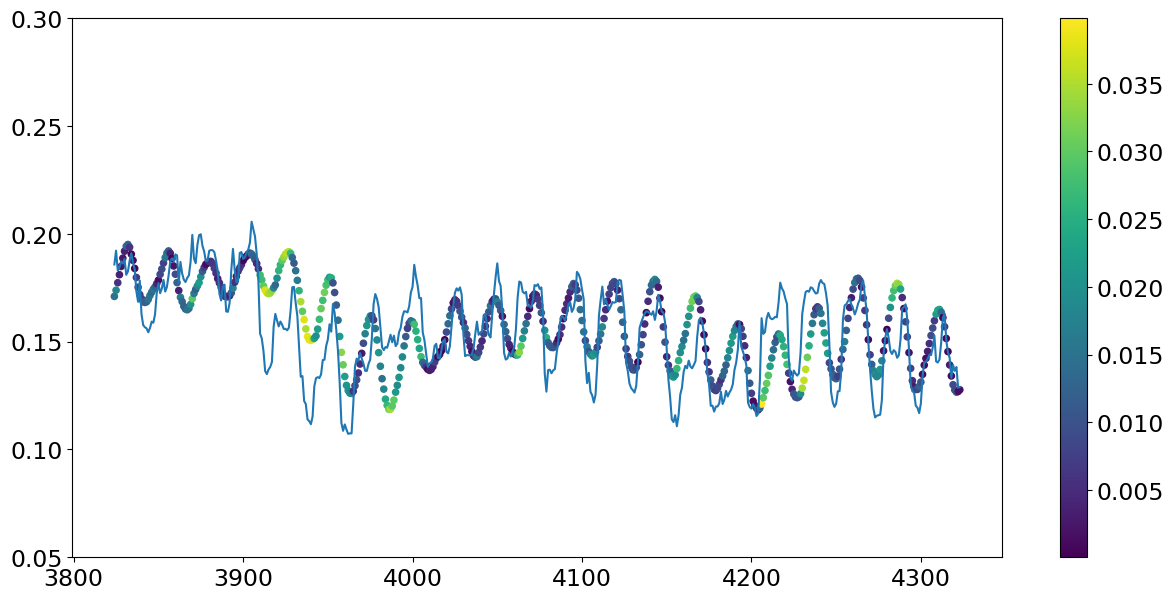

In [17]:
length = 500
idx_i = 3824
window = 24
idx_f = idx_i + length

plt.figure()
plt.plot(t[idx_i:idx_f], c[idx_i:idx_f])
plt.scatter(t[idx_i:idx_f], g[idx_i - window:idx_f - window], 20, abs(
    g[idx_i - window:idx_f - window]-c[idx_i:idx_f]))
plt.colorbar()
plt.ylim([0.05, 0.3])
plt.show()

In [27]:
sum(abs(g-c[:-24]) / c[:-24]) / len(g)

0.059352473063100736

In [48]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'same') / w

In [72]:
avg_window = [6, 12, 24, 48]
relative_errors = abs(g - c[:-24]) / c[:-24]
moving_avg_error_per_window = []
for w in avg_window:
    moving_avg_error_per_window.append(moving_average(relative_errors, w))

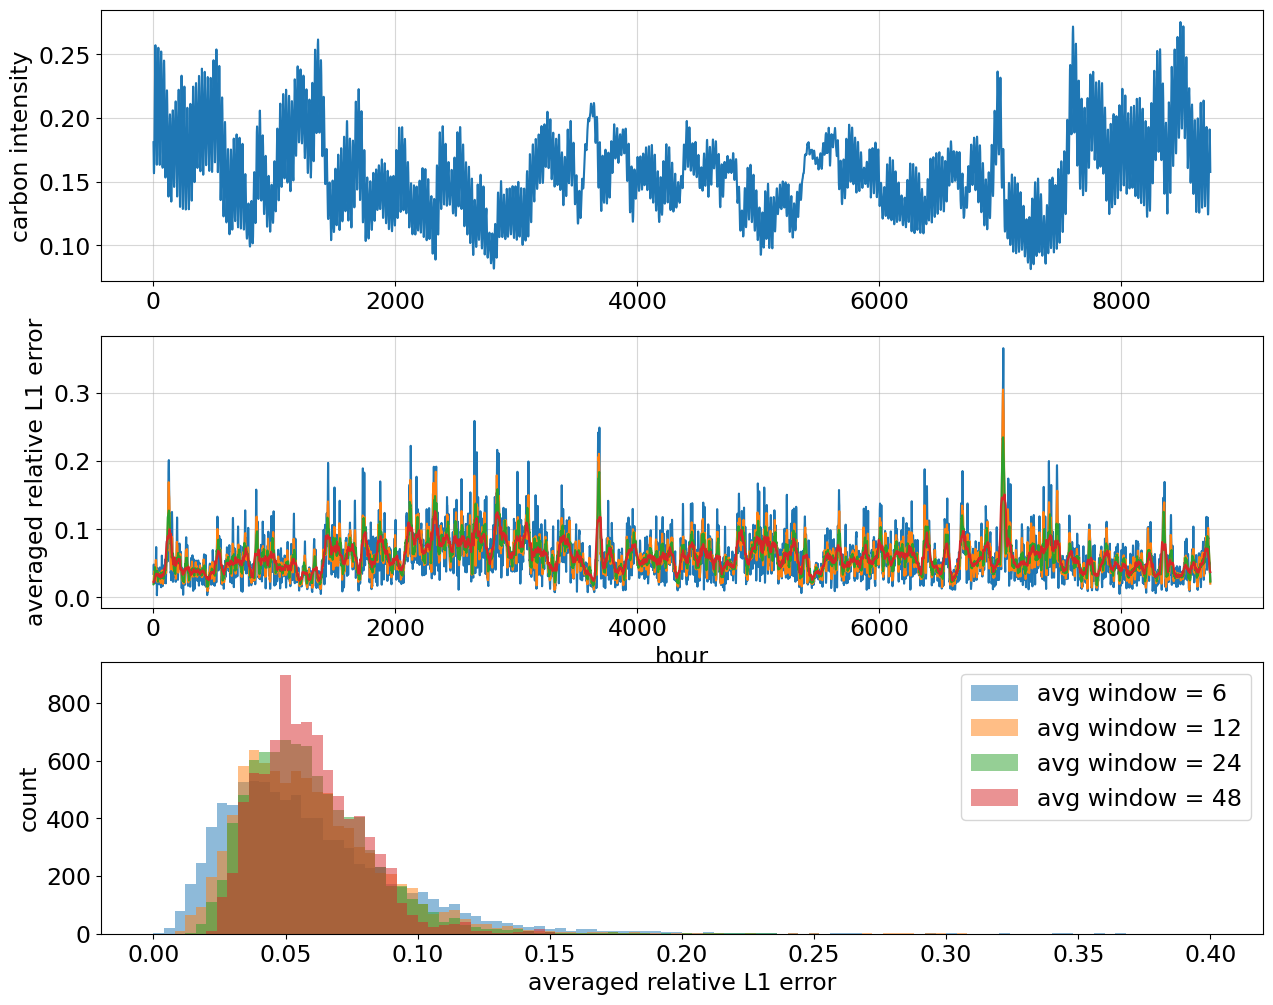

In [73]:
binwidth = 0.004
fig, ax = plt.subplots(3, 1, figsize=(15, 12))
ax[0].plot(t[:-24], g)
ax[0].set_ylabel("carbon intensity")
ax[0].grid(alpha=0.5)
for i, w in enumerate(avg_window):
    label = f"avg window = {w}"
    ax[1].plot(np.arange(len(g)), moving_avg_error_per_window[i], label=label)
    ax[2].hist(moving_avg_error_per_window[i], label=label, alpha=0.5, 
               bins=np.arange(0, 0.4 + binwidth, binwidth))
ax[1].set_xlabel("hour")
ax[2].set_xlabel("averaged relative L1 error")
ax[1].set_ylabel("averaged relative L1 error")
ax[2].set_ylabel("count")
ax[2].legend()
ax[1].grid(alpha=0.5)
plt.savefig("figures/statistics/sine_fit_error_plot.png")
plt.show()